## Conventional Time Series Models

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels
from src.preprocessing import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('kitCapstoneJan24_data.csv', delimiter=';')
a = df[df["countryname"] == "Country A"]
a = convert_month_to_date(a)

# Forecasting using statsmodels

<Axes: xlabel='date'>

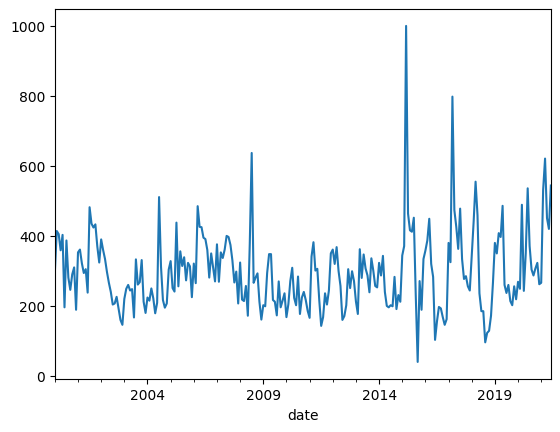

In [34]:
## take data from own vehiclegroup
a_1 = a[[col for col in a.columns if "vehiclegroup01" in col]]
data = a_1.rename(columns={'sales_actuals_monthly__vehiclegroup01__orderintake': 'order_intake'}).dropna(subset=['order_intake'], axis=0)
data['order_intake'].plot()

In [10]:
# prediciting last two years
train_data = data.iloc[:-24]
test_data = data.iloc[-24:]

## ACF and PACF for ARIMA

ACF describes the autocorrelation between an oberservation and another observation at a prior time step that includes direct and indirect dependence information

In [39]:
acf(data['order_intake'])

array([ 1.        ,  0.48413235,  0.30919818,  0.14794795,  0.02665538,
       -0.12538136, -0.13583215, -0.13460492, -0.08243906,  0.02105129,
        0.11278858,  0.15964054,  0.2632308 ,  0.12178546,  0.06479632,
       -0.03752457, -0.14093193, -0.14146686, -0.12770956, -0.19202187,
       -0.09534462,  0.00911413,  0.12953645,  0.16198135,  0.34461654])

In [40]:
pacf_yw(data['order_intake'], nlags=4, method='mle')
# pacf_ols(data['order_intake'], nlags=4)

array([ 1.        ,  0.48413235,  0.09771748, -0.04539791, -0.07003087])

In [41]:
from pandas.plotting import lag_plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

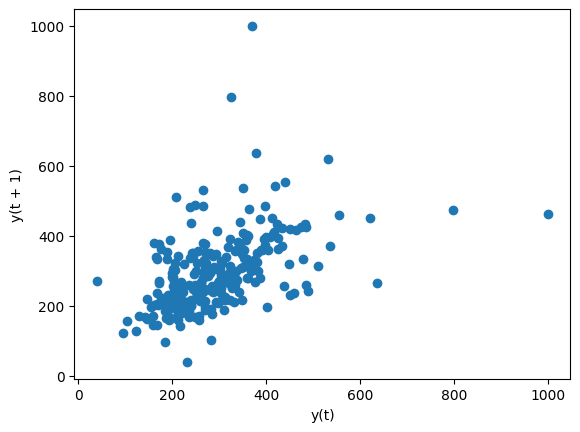

In [42]:
lag_plot(data['order_intake'])

### Statistical Tests
A stationary series has constant mean and variance over time,
can be tested with Dickey-Fuller Test

In [55]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [56]:
adf_test(data['order_intake'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.120375
p-value                   0.025082
# lags used              12.000000
# observations          245.000000
critical value (1%)      -3.457326
critical value (5%)      -2.873410
critical value (10%)     -2.573096
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [64]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(data[['customer_vehicle_relationships__vehiclegroup01__active_cars', 'order_intake']], maxlag=10);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1571  , p=0.0768  , df_denom=254, df_num=1
ssr based chi2 test:   chi2=3.1944  , p=0.0739  , df=1
likelihood ratio test: chi2=3.1747  , p=0.0748  , df=1
parameter F test:         F=3.1571  , p=0.0768  , df_denom=254, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9951  , p=0.3711  , df_denom=251, df_num=2
ssr based chi2 test:   chi2=2.0299  , p=0.3624  , df=2
likelihood ratio test: chi2=2.0219  , p=0.3639  , df=2
parameter F test:         F=0.9951  , p=0.3711  , df_denom=251, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4142  , p=0.0672  , df_denom=248, df_num=3
ssr based chi2 test:   chi2=7.4469  , p=0.0589  , df=3
likelihood ratio test: chi2=7.3403  , p=0.0618  , df=3
parameter F test:         F=2.4142  , p=0.0672  , df_denom=248, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7801  , p=0.1334  

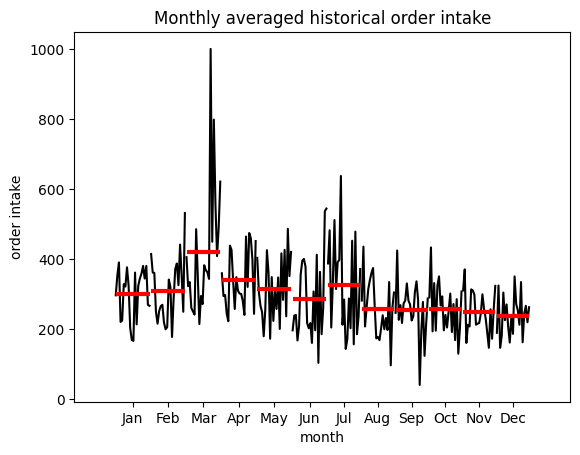

In [53]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from matplotlib.pyplot import savefig
fig = month_plot(data['order_intake'])
fig.axes[0].set_title('Monthly averaged historical order intake')
fig.axes[0].set_xlabel('month')
fig.axes[0].set_ylabel('order intake')

savefig('demo.png', transparent=True)


C:\Users\Patrick Rohrbeck\AppData\Local\Temp\ipykernel_19072\3179354746.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  dfq = data['order_intake'].resample(rule='Q').mean()


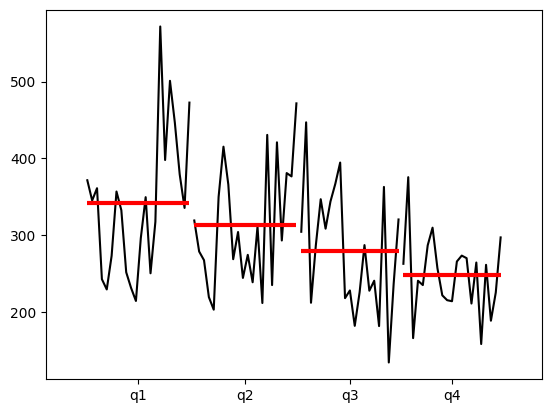

In [68]:
dfq = data['order_intake'].resample(rule='Q').mean()
quarter_plot(dfq);

In [5]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(data['order_intake'],start_p=0,start_q=0,seasonal=True,trace=True,m=12)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=3128.881, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3162.781, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3079.469, Time=0.45 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3105.978, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3704.413, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3094.568, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=3055.433, Time=1.78 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=3066.356, Time=1.48 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=3084.883, Time=0.72 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=3119.440, Time=1.68 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=3055.651, Time=2.95 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=3055.514, Time=2.50 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=3072.440, Time=1.55 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=3058.734, Time=1.49 sec
 ARIMA(1,0,0)(2,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  258
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -1522.716
Date:                            Thu, 01 Feb 2024   AIC                           3055.433
Time:                                    10:28:47   BIC                           3073.198
Sample:                                01-31-2000   HQIC                          3062.576
                                     - 06-30-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     77.8169     15.609      4.985      0.000      47.223     108.411
ar.L1          0.4786      0.049      9.695      0.000       0.382       0.575
ar.S.L12       0.1871      0.066      2.825      0.005       0.057       0.317
ar.S.L24       0.3216      0.042      7.574      0.000       0.238       0.405
sigma2      7717.8363    348.113     22.170      0.000    7035.547    8400.126
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):              1091.94
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
stepwise_fit = auto_arima(data['order_intake'],seasonal=True,m=12)
order = stepwise_fit.get_params()['order']
seasonal_order = stepwise_fit.get_params()['seasonal_order']

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 0, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [94]:
stepwise_fit = auto_arima(data['order_intake'],seasonal=False, trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3704.413, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3161.801, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3494.537, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3138.378, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3136.361, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3135.535, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3137.444, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3137.534, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3096.680, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3095.558, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3094.007, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3094.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1543.003
Date:                Wed, 31 Jan 2024   AIC                           3094.007
Time:                        11:46:05   BIC                           3108.219
Sample:                    01-31-2000   HQIC                          3099.721
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    134.7444     24.208      5.566      0.000      87.298     182.191
ar.L1          0.4449      0.054      8.226      0.000       0.339       0.551
ar.L2          0.1021      0.073      1.392      0.164      -0.042       0.246
sigma2      9174.6118    405.441     22.629      0.000    8379.961    9969.262
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1446.88
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                             2.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [99]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [120]:
# prediciting last two years
train_data = data.iloc[:-18]
test_data = data.iloc[-18:]

In [121]:
model = SARIMAX(train_data['order_intake'], order=(1,0,0), seasonal_order=(2,0,0,12))
result = model.fit()

MAPE:0.38781980892324525


<Axes: xlabel='date'>

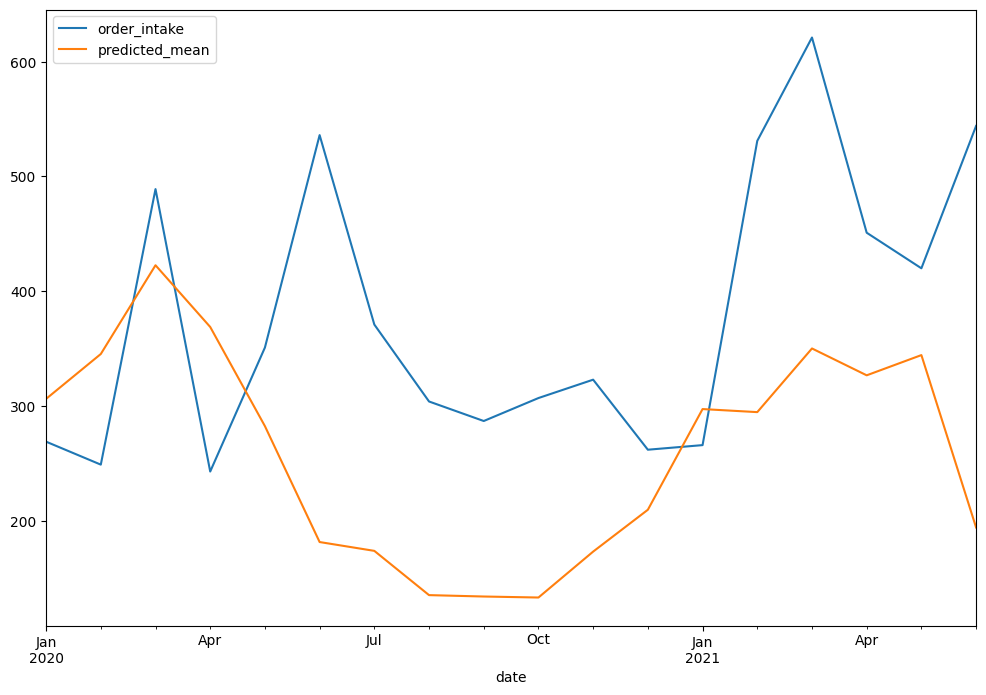

In [123]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = result.predict(start, end, type='levels')

print(f'MAPE:{mean_absolute_percentage_error(test_data["order_intake"], predictions)}')
test_data['order_intake'].plot(legend=True, figsize=(12,8))
predictions.plot(legend=True, figsize=(12,8))

MAPE:0.29923016074445896


<Axes: xlabel='date'>

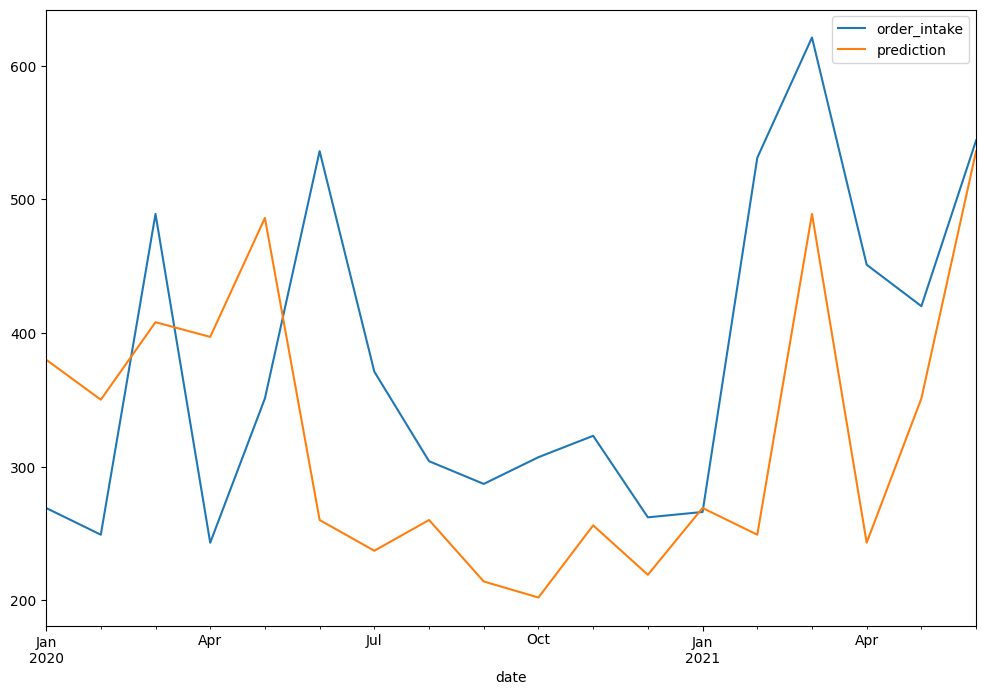

In [127]:
# using values from the year before
predictions = (data['2019-01':'2020-06']['order_intake'].values)
baseline = test_data.copy()
baseline['prediction'] = predictions

print(f'MAPE:{mean_absolute_percentage_error(baseline["order_intake"], baseline["prediction"])}')
baseline["order_intake"].plot(legend=True, figsize=(12,8))
baseline["prediction"].plot(legend=True, figsize=(12,8))


In [128]:
df = pd.read_csv('kitCapstoneJan24_data.csv', delimiter=';')
a = df[df["countryname"] == "Country A"]
a = convert_month_to_date(a)

c:\Users\Patrick Rohrbeck\Documents\Projekte\BIS\bis_capstone_project\src\preprocessing.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['month'].apply(month_to_datestring)
c:\Users\Patrick Rohrbeck\Documents\Projekte\BIS\bis_capstone_project\src\preprocessing.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%m/%y')


In [155]:
available = a['2000-01':'2022-12'].dropna(axis=1).drop(columns=['countryname']).columns
extern = a[available][:'2019-12']
extern_pred = a[available]['2020-01':'2021-06']

In [143]:
stepwise_fit = auto_arima(data['order_intake'],exogenous=extern,seasonal=True,trace=True,m=12)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3074.059, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3162.781, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3079.469, Time=0.47 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3105.978, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3704.413, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=3089.299, Time=0.42 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=3066.235, Time=1.73 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=3059.621, Time=1.42 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=3059.417, Time=1.41 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=3081.369, Time=1.06 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=3075.963, Time=1.52 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=3081.968, Time=0.74 sec
 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=3062.933, Time=1.15 sec
 ARIMA(1,0,1)(2,0,0)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  258
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -1522.716
Date:                            Wed, 31 Jan 2024   AIC                           3055.433
Time:                                    13:12:47   BIC                           3073.198
Sample:                                01-31-2000   HQIC                          3062.576
                                     - 06-30-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     77.8169     15.609      4.985      0.000      47.223     108.411
ar.L1          0.4786      0.049      9.695      0.000       0.382       0.575
ar.S.L12       0.1871      0.066      2.825      0.005       0.057       0.317
ar.S.L24       0.3216      0.042      7.574      0.000       0.238       0.405
sigma2      7717.8363    348.113     22.170      0.000    7035.547    8400.126
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):              1091.94
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [150]:
model = SARIMAX(train_data['order_intake'], exog=extern, order=(1,0,0), seasonal_order=(2,0,0,12))

c:\Users\Patrick Rohrbeck\AppData\Local\miniconda3\envs\BIS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE:4.293041029218223


<Axes: xlabel='date'>

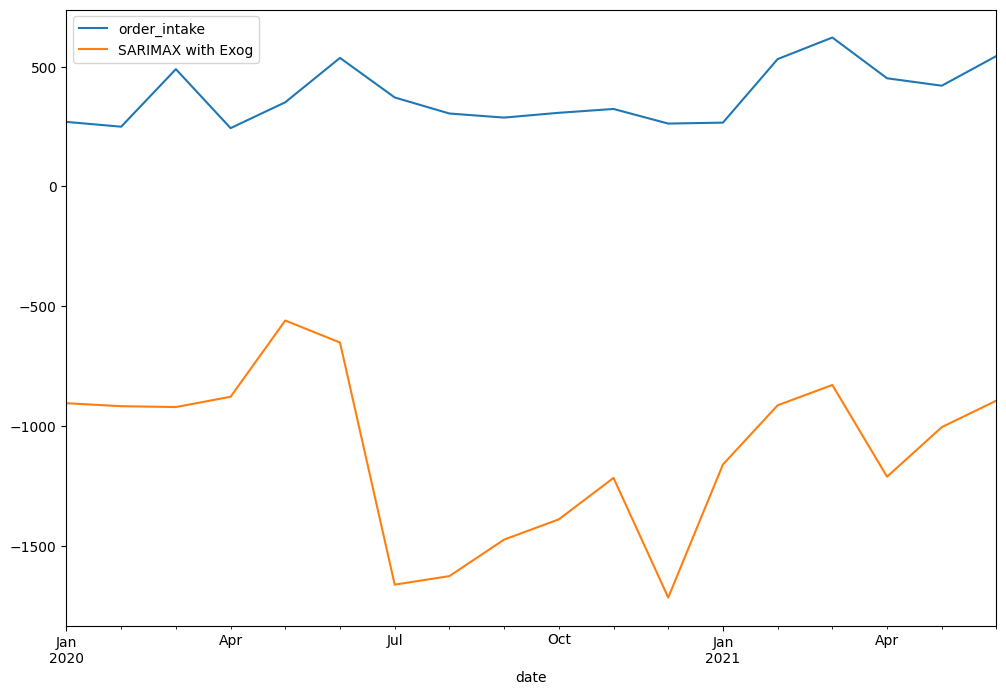

In [151]:
result = model.fit()

start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = result.predict(start, end, exog=extern_pred).rename('SARIMAX with Exog')

print(f'MAPE:{mean_absolute_percentage_error(test_data["order_intake"], predictions)}')
test_data['order_intake'].plot(legend=True, figsize=(12,8))
predictions.plot(legend=True, figsize=(12,8))

### Testing Framework for Time Series Analysis

In [290]:
from sklearn.metrics import mean_absolute_percentage_error as mape

In [393]:
def plot(results, category_names, total_values:int):
    """
    Plotting the splits for the cross validation.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['PRGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.invert_yaxis()
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    ax.set_title("Cross Validation Splits")
    ax.set_xticks(np.arange(0,total_values,12))
    ax.grid(which='major', axis='x')

    return fig, ax


def create_splits(df:pd.DataFrame,n_splits:int=5,overlap:int=0,test_size:int=18)->list:
    """
    Creating n splits for cross validation, starting with the latest data as test data and going backwards in time.
    """
    # remove all future rows with empty target variable
    df = df.dropna(subset=['sales_actuals_monthly__vehiclegroup01__orderintake'], axis=0)

    splits = []
    split_sizes = {}

    for split_no in range(1 , n_splits + 1):
        current = {}
        test_begin = (split_no * test_size - ((split_no-1) * overlap))
        current['train'] = df.iloc[:-test_begin]
        test_end  = len(current['train']) + test_size
        current['test'] = df.iloc[-test_begin:test_end]
        splits.append(current)
        split_sizes[f'split_{split_no}'] = [len(current['train']), len(current['test'])]

    # visualisation of splits
    split_names = ['train', 'test']
    plot(split_sizes, split_names, len(df))
    plt.show()

    return splits


def evaluate(results:list):
    """
    Expecting a list of dataframes, each containing a testset as well as a column in this set called 'prediction'.
    Visualizes and calculates metrics for each split as well as the overall performance.
    """
    mape_values = []
    for idx,result in enumerate(results):

        predictions = result['prediction']
        actual = result.rename(columns={'sales_actuals_monthly__vehiclegroup01__orderintake':'actual_orderintake'})['actual_orderintake']
        result['absolute percentage error'] = np.abs((actual - predictions) / actual)

        mape_score = mape(actual, predictions)
        mape_values.append(mape_score)

        predictions.plot(kind='line', legend=True, figsize=(8,6), title=f'Prediction for split_{idx+1}')
        actual.plot(kind='line', legend=True)
        plt.show()
        
        result['absolute percentage error'].plot(legend=True, kind='bar', figsize=(8,3), width=0.1)
        plt.axhline(y=mape_score, color='b')
        plt.show()

        print(f'Prediction mean: {predictions.mean()}')
        print(f'MAPE: {mape_score}')
        print('_________________________________________________________________________________________')

    print(f'Overall Result: {np.mean(mape_values)}')

In [303]:
# import data
df = pd.read_csv('kitCapstoneJan24_data.csv', delimiter=';')
a = df[df["countryname"] == "Country A"]
a = convert_month_to_date(a)


c:\Users\Patrick Rohrbeck\Documents\Projekte\BIS\bis_capstone_project\src\preprocessing.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['month'].apply(month_to_datestring)
c:\Users\Patrick Rohrbeck\Documents\Projekte\BIS\bis_capstone_project\src\preprocessing.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%m/%y')


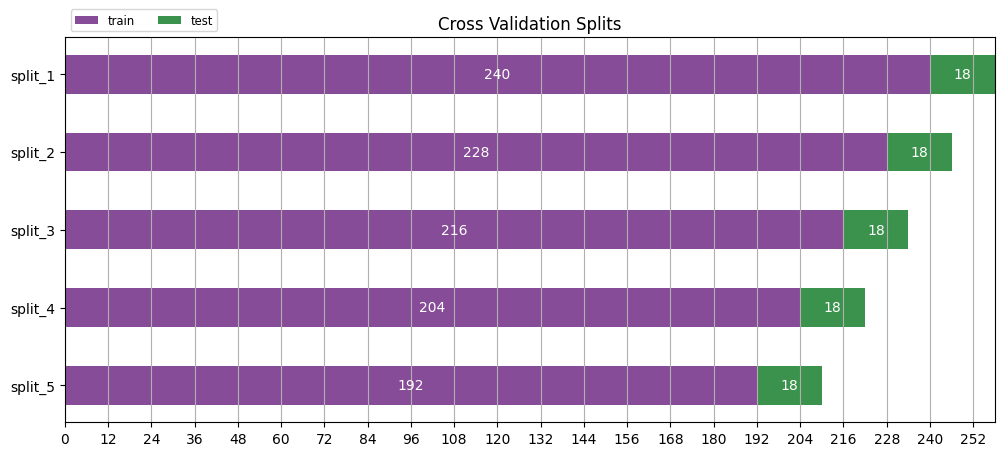

In [329]:
splits = create_splits(a, overlap=6)

In [380]:
results = []

for split in splits:
    train = split['train']
    test = split['test']


    #### Train your model in here ####
    from statsmodels.tsa.holtwinters import ExponentialSmoothing

    fitted_model = ExponentialSmoothing(train['sales_actuals_monthly__vehiclegroup01__orderintake'],
                                    trend='add',
                                    seasonal='mul',
                                    seasonal_periods=12).fit()
    
    predictions = fitted_model.forecast(18)
    #### Train your model in here ####

    test['prediction'] = predictions
    results.append(test)

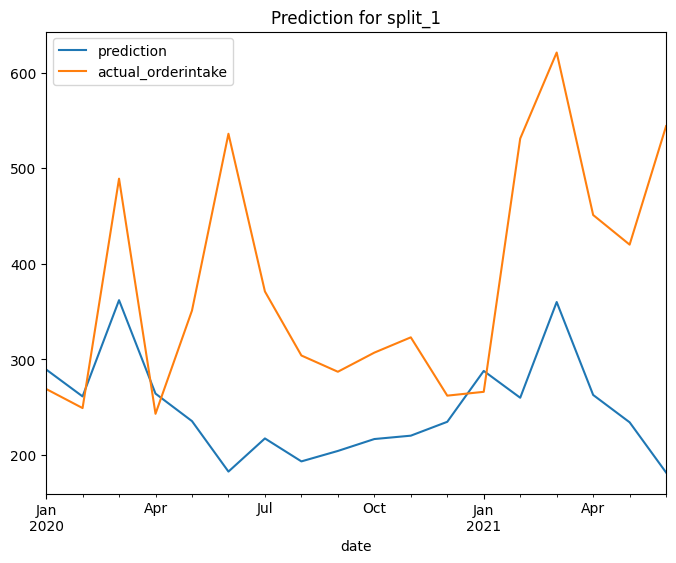

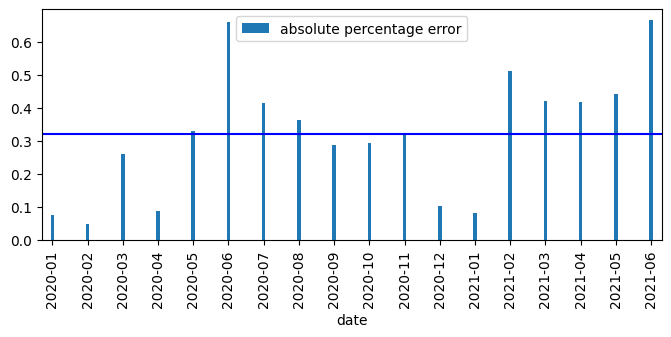

Prediction mean: 248.13420675678515
MAPE: 0.32140627431299135
_________________________________________________________________________________________


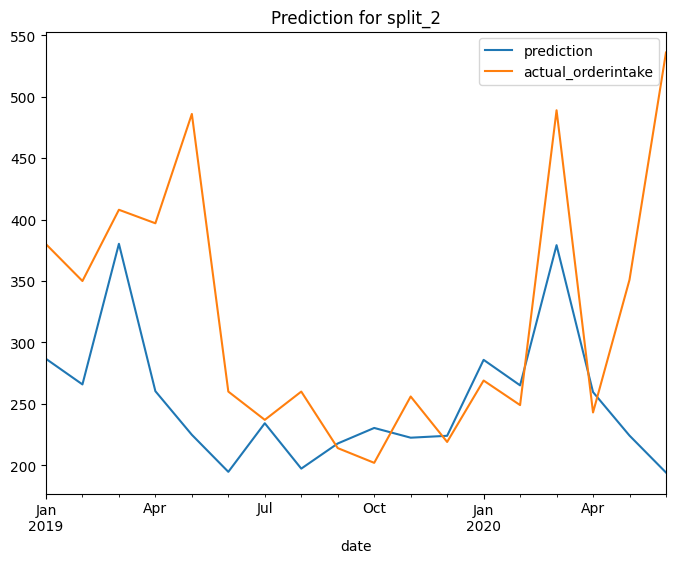

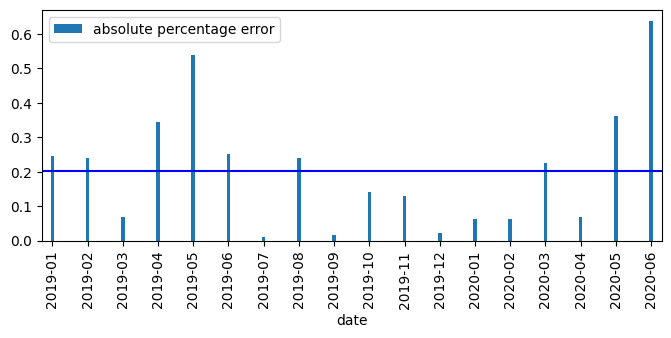

Prediction mean: 252.59694501699394
MAPE: 0.20393344574147043
_________________________________________________________________________________________


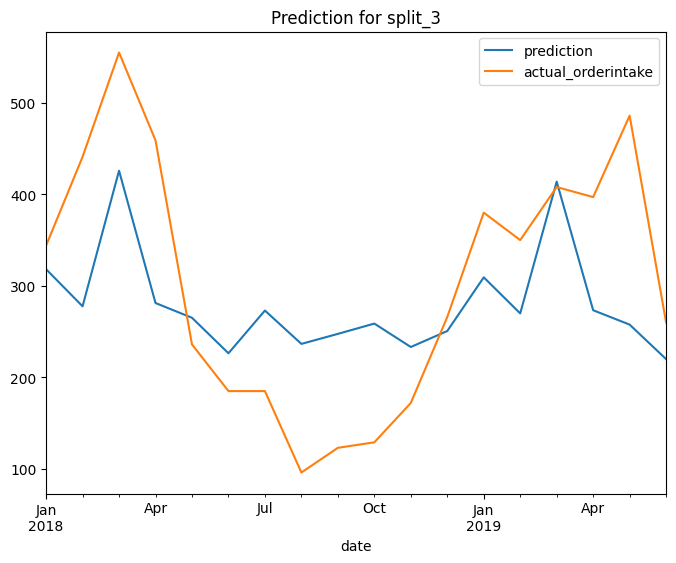

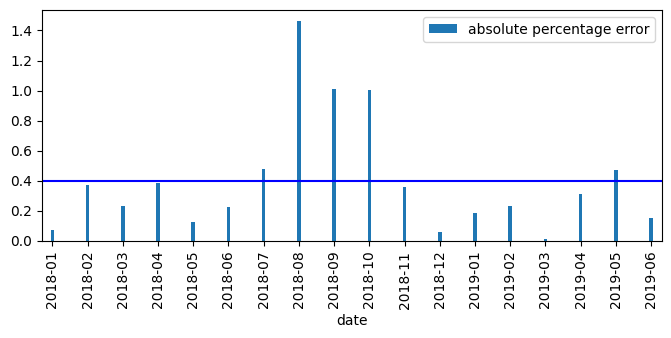

Prediction mean: 279.89592728627866
MAPE: 0.3971526764282068
_________________________________________________________________________________________


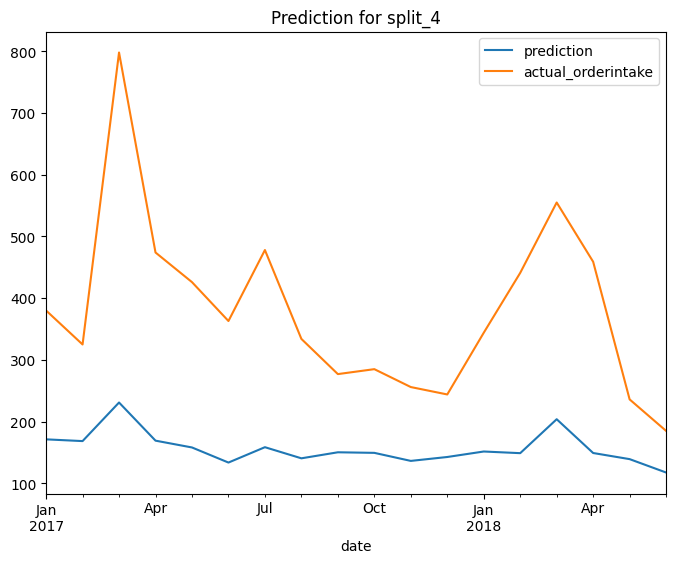

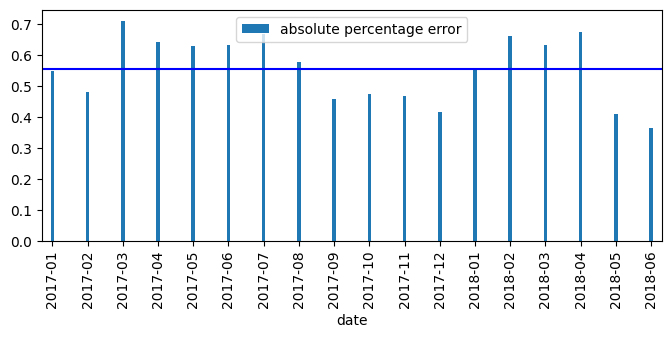

Prediction mean: 156.6588028036246
MAPE: 0.5562425005888482
_________________________________________________________________________________________


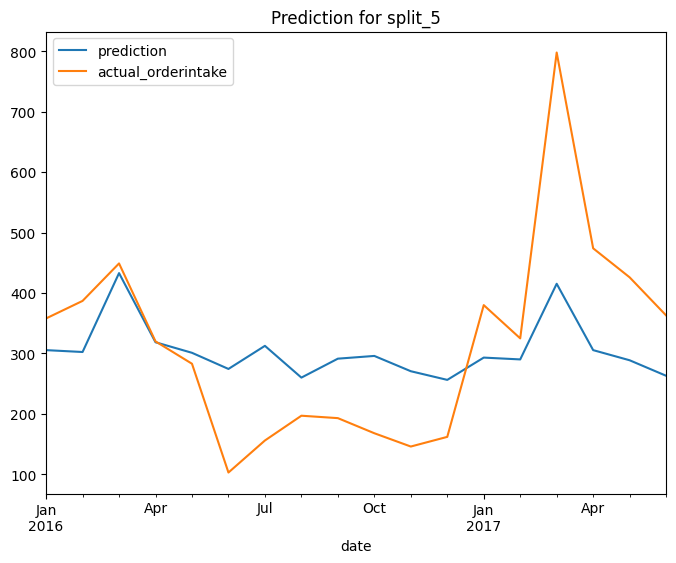

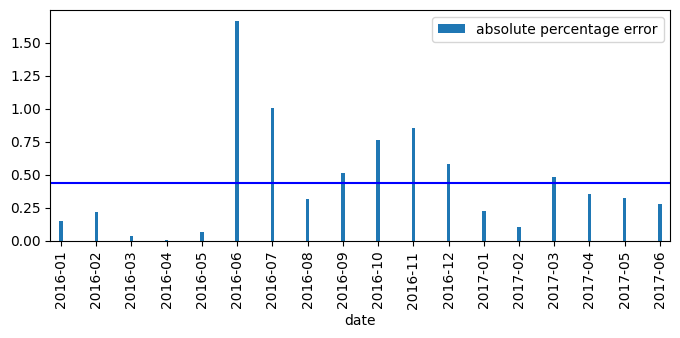

Prediction mean: 304.33356709079794
MAPE: 0.4406857686808184
_________________________________________________________________________________________
Overall Result: 0.38388413315046704


In [394]:
evaluate(results)

In [ ]:
df = pd.read_csv('kitCapstoneJan24_data.csv', delimiter=';')
a = df[df["countryname"] == "Country A"]
a = convert_month_to_date(a)

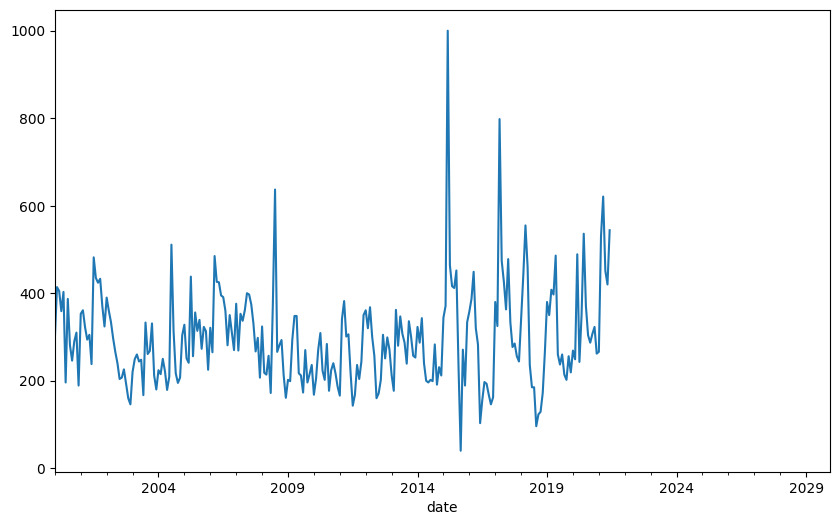

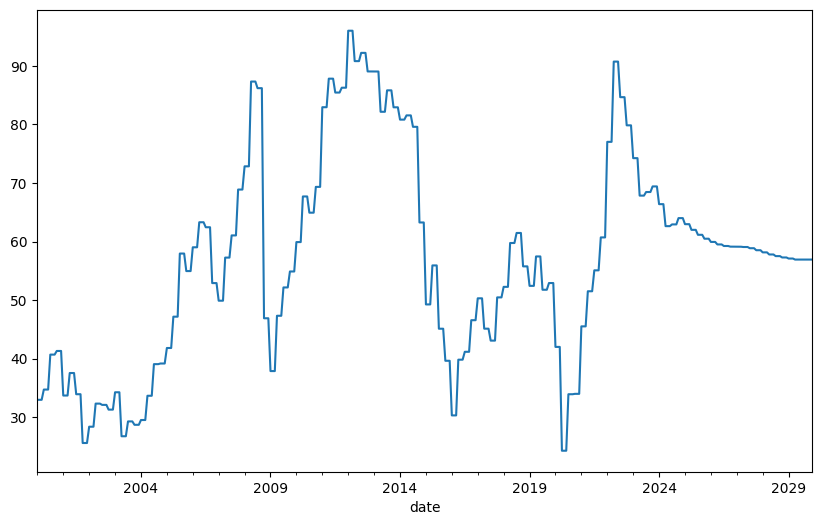

In [28]:
a[ 'sales_actuals_monthly__vehiclegroup01__orderintake'].plot(figsize=(10,6))
plt.show()
a['global_economy__real_price_of_crude_oil_lcu_basis__euro'].plot(figsize=(10,6))
plt.show()

### Creation of PowerBI Dataset

In [60]:
def month_to_datestring(month: int) -> str:
    # Startpunkt Januar 2001
    m = (month - 1) % 12 + 1
    m_string = str(m) if m > 9 else '0' + str(m)
    y = ((month-1) // 12) +1
    y_string = str(y) if y > 9 else '0' + str(y)
    
    return f'{m_string}/{y_string}'


def convert_month_to_date(df: pd.DataFrame) -> pd.DataFrame:
    """Takes a dataframe with a month column and transforms it to a date column of type datetime.

    Args:
        df (pd.DataFrame): Dataframe to transform

    Returns:
        pd.DataFrame: Transformed dataframe
    """
    df['date'] = df['month'].apply(month_to_datestring)
    df['date'] = pd.to_datetime(df['date'], format='%m/%y')
    result = df.set_index('date').drop(['month'], axis=1)
    #result.index = pd.DatetimeIndex(result.index).to_period('M')

    return result.sort_index()

In [161]:
df = pd.read_csv('kitCapstoneJan24_data.csv', delimiter=';')
df = convert_month_to_date(df)

# df
df['date'] = df.index
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')  # Change the format accordingly
columns_to_keep = ['sales_actuals_monthly__vehiclegroup01__orderintake', 'countryname', 'date']
df = df[columns_to_keep]
df = df.dropna(subset=['sales_actuals_monthly__vehiclegroup01__orderintake'], axis=0)
df['sales_predicted_monthly__vehiclegroup01__orderintake'] = 0


## predictions
predictions = pd.read_csv('both_predictions.csv', parse_dates=True, index_col='Unnamed: 0')
predictions.index = predictions.index + pd.DateOffset(years=1)
predictions['date'] = predictions.index
predictions['date'] = pd.to_datetime(predictions['date'], format='%Y-%m-%d')  # Change the format accordingly
predictions['countryname'] = 'Country A'
predictions['sales_actuals_monthly__vehiclegroup01__orderintake'] = 0
predictions['sales_predicted_monthly__vehiclegroup01__orderintake'] = np.around(0.7 * predictions['prediction'] + 0.3 * predictions['prediction2'])
predictions = predictions.drop(columns=['prediction', 'prediction2'])

df = pd.concat([df, predictions])

df['sales_actuals_monthly__vehiclegroup01__orderintake'] = df['sales_actuals_monthly__vehiclegroup01__orderintake'].astype(int)
df['sales_predicted_monthly__vehiclegroup01__orderintake'] = df['sales_predicted_monthly__vehiclegroup01__orderintake'].astype(int)
df['previous_year_order_intake'] = 0


## adding order intakes from previous years
for idx, (_, row) in enumerate(df.iterrows()):

    country = row['countryname']
    date = row['date']
    prev = date - pd.DateOffset(years=1)

    country_df = df[df['countryname'] == country]

    if prev in country_df.index.values:
        value = country_df.loc[prev]['sales_actuals_monthly__vehiclegroup01__orderintake']
    else:
        value = 0
    
    df.iloc[idx, df.columns.get_loc('previous_year_order_intake')] = value

In [160]:
df.to_csv('data/power_bi_data.csv')